In [1]:
%tensorflow_version 1.x
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
from keras.models import Sequential
init_notebook_mode(connected=True)


TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [3]:
!git clone https://github.com/saisriteja/emotion-recognition.git

Cloning into 'emotion-recognition'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [0]:
import os
import glob
files = glob.glob('/content/emotion-recognition/data/*.zip')

In [5]:
for i in files:
  !unzip $i

Archive:  /content/emotion-recognition/data/KL_testing.zip
  inflating: KL_testing.pkl          
Archive:  /content/emotion-recognition/data/DC_testing.zip
  inflating: DC_testing.pkl          
Archive:  /content/emotion-recognition/data/JK_training.zip
  inflating: JK_training.pkl         
Archive:  /content/emotion-recognition/data/DC_training.zip
  inflating: DC_training.pkl         
Archive:  /content/emotion-recognition/data/JK_testing.zip
  inflating: JK_testing.pkl          
Archive:  /content/emotion-recognition/data/KL_training.zip
  inflating: KL_training.pkl         
Archive:  /content/emotion-recognition/data/JE_testing.zip
  inflating: JE_testing.pkl          
Archive:  /content/emotion-recognition/data/JE_training.zip
  inflating: JE_training.pkl         


In [0]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
import numpy as np
import pickle

In [8]:
SAVEE_data_training = np.array(load_obj('/content/KL_training'))
SAVEE_data_testing = np.array(load_obj('/content/KL_testing'))
print(SAVEE_data_training.shape)
print(SAVEE_data_testing.shape)

(106, 3)
(14, 3)


In [9]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
from keras.models import Sequential
init_notebook_mode(connected=True)
%matplotlib inline

In [10]:
train_imgs = []
train_landm = []
train_label = []

test_imgs = []
test_landm = []
test_label = []

for i,j,k in SAVEE_data_training:
  train_imgs.append(i)
  train_landm.append(j)
  train_label.append(k)

for i,j,k in SAVEE_data_testing:
  test_imgs.append(i)
  test_landm.append(j)
  test_label.append(k)

train_imgs = np.array(train_imgs)
test_imgs= np.array(test_imgs)

X = np.concatenate((train_imgs, test_imgs), axis=0)

X_min = 1000
for i in X:
  m = i.shape[0]
  #print(m)

  if m < X_min:
    X_min = m
print(X_min)

def framegene(X):
  X_ref = []

  no = X_min
  for i in X:
    length = i.shape[0]
    if length>no:
        frame_length = int((length-no)/2)
        X_ref.append((i[frame_length:frame_length+no]))
    else:
        X_ref.append(i)
  return np.array(X_ref)

X_train = framegene(train_imgs)
X_test = framegene(test_imgs)

print(X_train.shape)
print(X_test.shape)

y_train = np.array(train_label)
y_test = np.array(test_label)

print(y_train.shape)
print(y_test.shape)

y_train = keras.utils.to_categorical(y_train, 7)
y_test = keras.utils.to_categorical(y_test, 7)

98
(106, 98, 28, 28, 3)
(14, 98, 28, 28, 3)
(106,)
(14,)


In [11]:

## input layer
input_layer = Input((X_min, 28, 28, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=7, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 98, 28, 28, 3)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 96, 26, 26, 8)     656       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 94, 24, 24, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 47, 12, 12, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 45, 10, 10, 32)    13856     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 43, 8, 8, 64)      55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 21, 4, 4, 64)      0   

In [13]:
X_train.shape

(106, 98, 28, 28, 3)

In [14]:
y_train.shape

(106, 7)

In [15]:
from keras.callbacks import EarlyStopping
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
es = EarlyStopping(monitor='val_loss',verbose =1, patience=50)
history = model.fit(x=X_train, y=y_train, batch_size=4, epochs=50,verbose=1, validation_split=0.2,callbacks=[es])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 84 samples, validate on 22 samples
Epoch 1/50





84/84 [==============================] - 16s 187ms/step - loss: 5.7608 - acc: 0.2381 - val_loss: 4.2318 - val_acc: 0.2273
Epoch 2/50
84/84 [==============================] - 2s 19ms/step - loss: 4.8170 - acc: 0.2262 - val_loss: 2.7420 - val_acc: 0.1818
Epoch 3/50
84/84 [==============================] - 2s 19ms/step - loss: 3.2104 - acc: 0.2857 - val_loss: 4.3624 - val_acc: 0.1818
Epoch 4/50
84/84 [==============================] - 2s 20ms/step - loss: 2.3995 - acc: 0.4048 - val_loss: 4.1397 - val_acc: 0.2273
Epoch 5/50
84/84 [==============================] - 2s 19ms/step - loss: 1.0380 - acc: 0.6667 - val_loss: 3.0754 - val_acc: 0.2727
Epoch 6/50
84/84 [==============================] - 2s 19ms/step - loss: 0.7034 - acc: 0.8095 - val_loss: 1.9065 - val_acc: 0.4545
Epoch 7/50
84/84 [==============================] - 2s 20ms/step

Train: 0.962, Test: 0.857


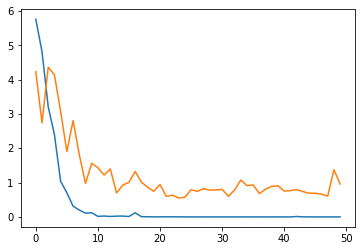

In [16]:
import matplotlib.pyplot as plt
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

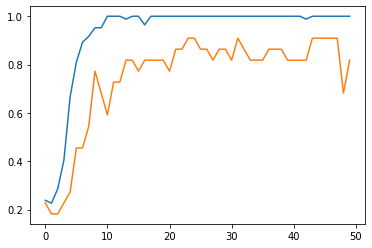

In [17]:
plt.plot(history.history['acc'],label = 'acc')
plt.plot(history.history['val_acc'],label = 'val_acc')

In [18]:

y_pred = model.predict(X_test)
y_pred.argmax(axis=1)

#y_pred = keras.utils.to_categorical(pred, 7)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[2, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 1, 0, 0, 1]])

In [0]:
#from sklearn.metrics import plot_confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

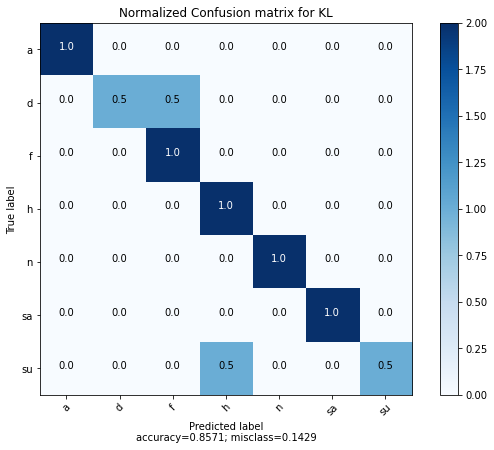

In [21]:
#from sklearn.metrics import plot_confusion_matrix
target_names = ['a','d','f','h','n','sa','su']
cm =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plot_confusion_matrix(cm,target_names,title='Normalized Confusion matrix for KL',cmap=None,normalize=True)